In [3]:
climate4R <- list("loadeR", "transformeR", "downscaleR", "visualizeR", "climate4R.climdex")
lapply(climate4R, require, character.only = TRUE) 

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

In [4]:
library(devtools)
library(tidyverse)
library(caret)

Cargamos los datos de precicipitación, temperatura y los índices climáticos.

In [5]:
load("./pr_MAM.rda",verbose = T)
load("./tas_MAM.rda",verbose = T)
load("./indices_MAM.rda",verbose = T)
load("./indices_MAM_LT1.rda",verbose = T)
load("./indices_MAM_LT4.rda",verbose = T)

Loading objects:
  data_MAM
Loading objects:
  data_MAM_temp
Loading objects:
  indices_MAM
Loading objects:
  indices_MAM_LT1
Loading objects:
  indices_MAM_LT4


In [6]:
# métrica de validación: RMSE
rmse <- function(obs, pred) {  
  sqrt(mean((obs - pred)^2,na.rm = TRUE))
  
}
# métrica de años acertados
acc <- function(obs,pred){
    terciles = quantile(obs, probs = c(.33,.66,1), na.rm = TRUE)
    if (terciles[1]==terciles[2]){
        terciles[2] = terciles[1] + 1/10000
    }
    if (terciles[1]==terciles[3]){
        terciles[3] = terciles[1] + 1/10000
    }
    if (terciles[2]==terciles[3]){
        terciles[3] = terciles[2] + 1/10000
    }
    x = cut(obs, breaks = c(-Inf,terciles), labels = c("lower","mid",
                                                 "upper"))
    terciles_pred = quantile(pred, probs = c(.33,.66,1), na.rm = TRUE)
    if (terciles_pred[1]==terciles_pred[2]){
        terciles_pred[2] = terciles_pred[1] + 1/10000
    }
    if (terciles_pred[1]==terciles_pred[3]){
        terciles_pred[3] = terciles_pred[1] + 1/10000
    }
    if (terciles_pred[2]==terciles_pred[3]){
        terciles_pred[3] = terciles_pred[2] + 1/10000
    }
    y = cut(pred, breaks = c(-Inf,terciles_pred), labels = c("lower","mid",
                                                 "upper"))
    z = length(which(x==y))
    
    return (z/length(obs))
}

In [7]:
predict_pr_regression = data_MAM
predict_tas_regression = data_MAM_temp
predict_pr_regression_LT1 = data_MAM
predict_tas_regression_LT1 = data_MAM_temp
predict_pr_regression_LT4 = data_MAM
predict_tas_regression_LT4 = data_MAM_temp

In [8]:
start_time = Sys.time()

for(iyear in 1:dim(data_MAM$Data)[1]){
    for(i in 1:length(data_MAM$xyCoords$x)){
        for(j in 1:length(data_MAM$xyCoords$y)){
            if(length(which(is.na(data_MAM$Data[,j,i])==FALSE))>2){
                indices_MAM$grid = data_MAM$Data[, j,i]
                indices_MAM_LT1$grid = data_MAM$Data[, j,i]
                indices_MAM_LT4$grid = data_MAM$Data[, j,i]
                mod= lm(grid ~., data = indices_MAM[-iyear,],
                       na.action = na.omit)
                

                pred = predict(mod, indices_MAM[iyear,])
                pred_LT1 = predict(mod, indices_MAM_LT1[iyear,])
                pred_LT4 = predict(mod, indices_MAM_LT4[iyear,])
                
                predict_pr_regression$Data[iyear,j,i] = pred
                predict_pr_regression_LT1$Data[iyear,j,i] = pred_LT1
                predict_pr_regression_LT4$Data[iyear,j,i] = pred_LT4
            }
        }
    }
}

end_time = Sys.time()
print(end_time - start_time)



Time difference of 1.422279 hours


In [9]:
start_time = Sys.time()

for(iyear in 1:dim(data_MAM_temp$Data)[1]){
    for(i in 1:length(data_MAM_temp$xyCoords$x)){
        for(j in 1:length(data_MAM_temp$xyCoords$y)){
            if(length(which(is.na(data_MAM_temp$Data[,j,i])==FALSE))>2){
                indices_MAM$grid = data_MAM_temp$Data[, j,i]
                indices_MAM_LT1$grid = data_MAM$Data[, j,i]
                indices_MAM_LT4$grid = data_MAM$Data[, j,i]

                mod = lm(grid ~nina+oni+nao+poleur+ea+eawr+pna+scand+soi+wp, data = indices_MAM[-iyear,],
                        na.action = na.omit)

                pred = predict(mod, indices_MAM[iyear,])
                pred_LT1 = predict(mod, indices_MAM_LT1[iyear,])
                pred_LT4 = predict(mod, indices_MAM_LT4[iyear,])
                
                predict_tas_regression$Data[iyear,j,i] = pred
                predict_tas_regression_LT1$Data[iyear,j,i] = pred_LT1
                predict_tas_regression_LT4$Data[iyear,j,i] = pred_LT4
            }
        }
    }
}

end_time = Sys.time()
print(end_time - start_time)

Time difference of 1.436509 hours


In [10]:
save(predict_pr_regression, file = "predict_pr_regression.rda") 
save(predict_pr_regression_LT1, file = "predict_pr_regression_LT1.rda") 
save(predict_pr_regression_LT4, file = "predict_pr_regression_LT4.rda") 
save(predict_tas_regression, file = "predict_tas_regression.rda") 
save(predict_tas_regression_LT1, file = "predict_tas_regression_LT1.rda") 
save(predict_tas_regression_LT4, file = "predict_tas_regression_LT4.rda") 

In [11]:
rmse_pr_regression = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_pr_regression = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
rmse_pr_regression_LT1 = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_pr_regression_LT1 = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
rmse_pr_regression_LT4 = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_pr_regression_LT4 = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
for(i in 1:length(data_MAM$xyCoords$x)){
    for(j in 1:length(data_MAM$xyCoords$y)){
        if(length(which(is.na(data_MAM$Data[,j,i])==FALSE))>2){
            rmse_pr_regression[j,i] = rmse(data_MAM$Data[,j,i],predict_pr_regression$Data[,j,i])
            acc_pr_regression[j,i] = acc(data_MAM$Data[,j,i],predict_pr_regression$Data[,j,i])
            
            rmse_pr_regression_LT1[j,i] = rmse(data_MAM$Data[,j,i],predict_pr_regression_LT1$Data[,j,i])
            acc_pr_regression_LT1[j,i] = acc(data_MAM$Data[,j,i],predict_pr_regression_LT1$Data[,j,i])
            
            rmse_pr_regression_LT4[j,i] = rmse(data_MAM$Data[,j,i],predict_pr_regression_LT4$Data[,j,i])
            acc_pr_regression_LT4[j,i] = acc(data_MAM$Data[,j,i],predict_pr_regression_LT4$Data[,j,i])
            
       }
    }
}

rmse_tas_regression = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
acc_tas_regression= matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
rmse_tas_regression_LT1 = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
acc_tas_regression_LT1= matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
rmse_tas_regression_LT4 = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
acc_tas_regression_LT4 = matrix(NA, nrow = length(data_MAM_temp$xyCoords$y), ncol = length(data_MAM_temp$xyCoords$x))
for(i in 1:length(data_MAM_temp$xyCoords$x)){
    for(j in 1:length(data_MAM_temp$xyCoords$y)){
        if(length(which(is.na(data_MAM_temp$Data[,j,i])==FALSE))>2){
            rmse_tas_regression[j,i] = rmse(data_MAM_temp$Data[,j,i],predict_tas_regression$Data[,j,i])
            acc_tas_regression[j,i] = acc(data_MAM_temp$Data[,j,i],predict_tas_regression$Data[,j,i])
            
            rmse_tas_regression_LT1[j,i] = rmse(data_MAM_temp$Data[,j,i],predict_tas_regression_LT1$Data[,j,i])
            acc_tas_regression_LT1[j,i] = acc(data_MAM_temp$Data[,j,i],predict_tas_regression_LT1$Data[,j,i])
            
            rmse_tas_regression_LT4[j,i] = rmse(data_MAM_temp$Data[,j,i],predict_tas_regression_LT4$Data[,j,i])
            acc_tas_regression_LT4[j,i] = acc(data_MAM_temp$Data[,j,i],predict_tas_regression_LT4$Data[,j,i])
       }
    }
}

In [12]:
makeC4R = function(data, template) {  # creates a C4R object from the "data" matrix
  C4R = template; C4R$Data = data; attributes(C4R$Data) = attributes(template$Data)
  return(C4R)
}
template = subsetDimension(data_MAM, dimension = "time", indices = 1)
rmse_pr_regression= makeC4R(rmse_pr_regression,template)
acc_pr_regression= makeC4R(acc_pr_regression,template)
rmse_pr_regression_LT1 = makeC4R(rmse_pr_regression_LT1,template)
acc_pr_regression_LT1 = makeC4R(acc_pr_regression_LT1,template)
rmse_pr_regression_LT4= makeC4R(rmse_pr_regression_LT4,template)
acc_pr_regression_LT4= makeC4R(acc_pr_regression_LT4,template)

rmse_tas_regression= makeC4R(rmse_tas_regression,template)
acc_tas_regression= makeC4R(acc_tas_regression,template)
rmse_tas_regression_LT1= makeC4R(rmse_tas_regression_LT1,template)
acc_tas_regression_LT1= makeC4R(acc_tas_regression_LT1,template)
rmse_tas_regression_LT4= makeC4R(rmse_tas_regression_LT4,template)
acc_tas_regression_LT4= makeC4R(acc_tas_regression_LT4,template)

In [13]:
library(RColorBrewer)
colstx <- rev(brewer.pal(n = 9, "Spectral"))
colsindex <- rev(brewer.pal(n = 9, "RdYlBu"))
colsdelta <- brewer.pal(n = 9, "Reds")
colsbias <- brewer.pal(n = 9, "PiYG")
colssd <- brewer.pal(n = 9, "Blues")

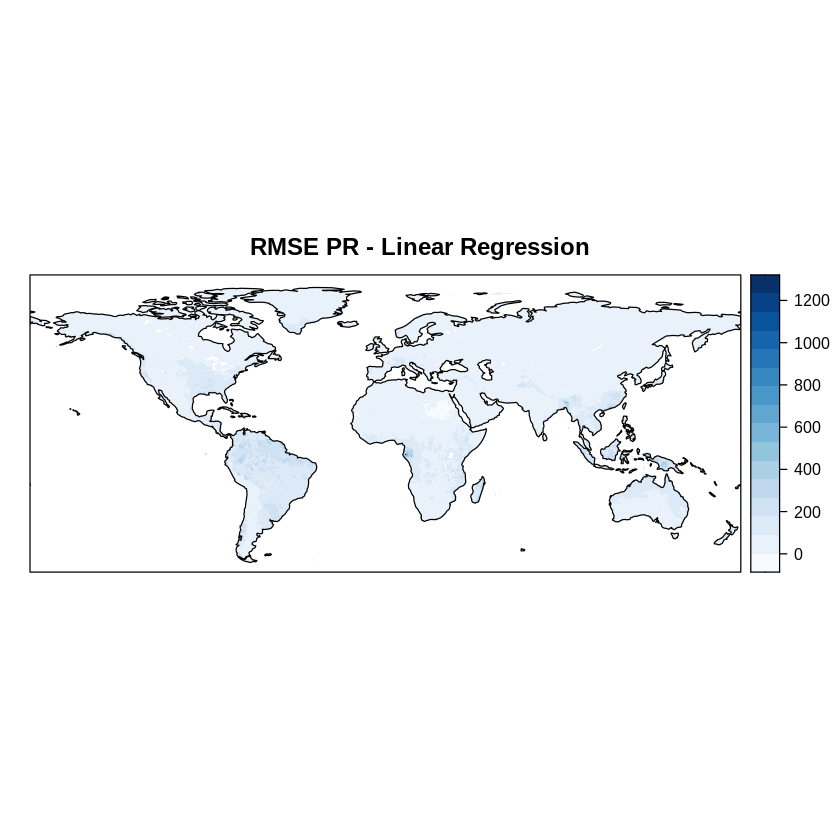

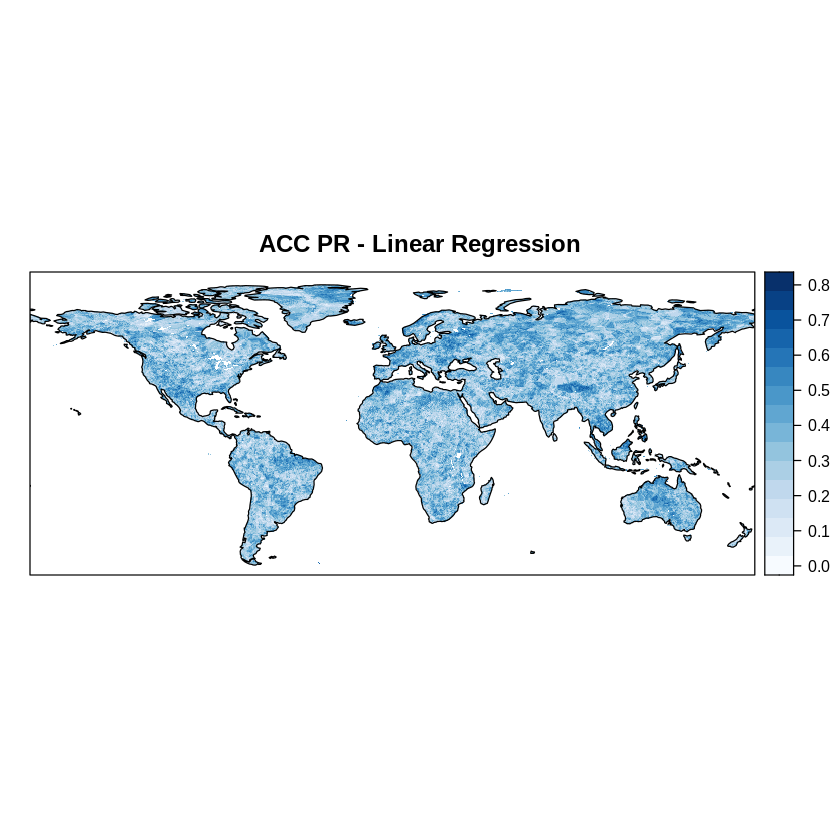

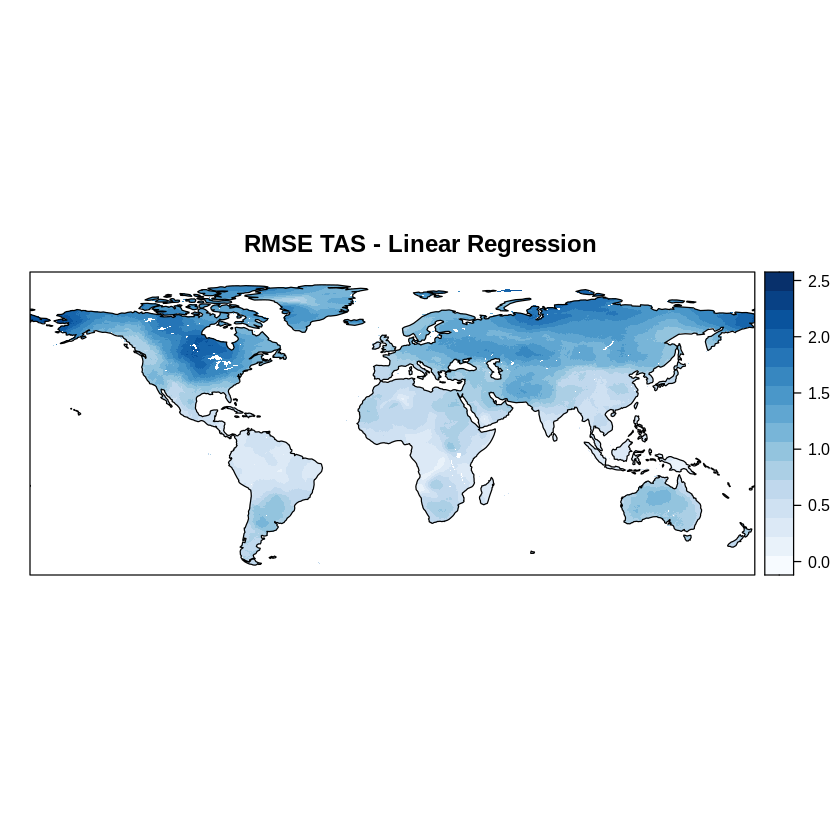

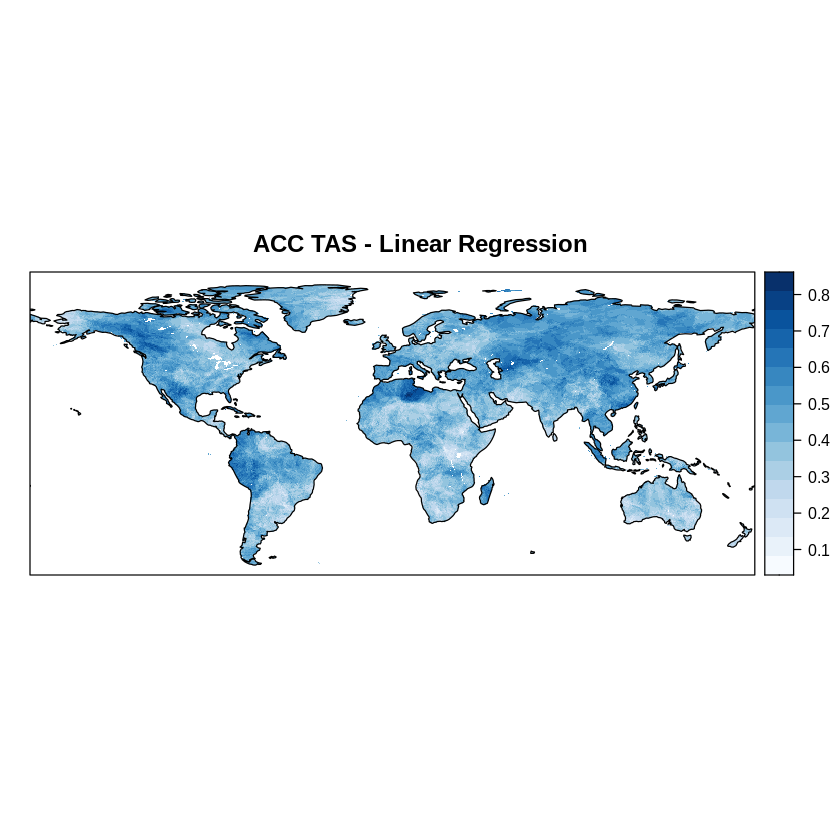

In [14]:
spatialPlot(rmse_pr_regression, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE PR - Linear Regression')
spatialPlot(acc_pr_regression, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC PR - Linear Regression')
spatialPlot(rmse_tas_regression, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE TAS - Linear Regression')
spatialPlot(acc_tas_regression, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC TAS - Linear Regression')

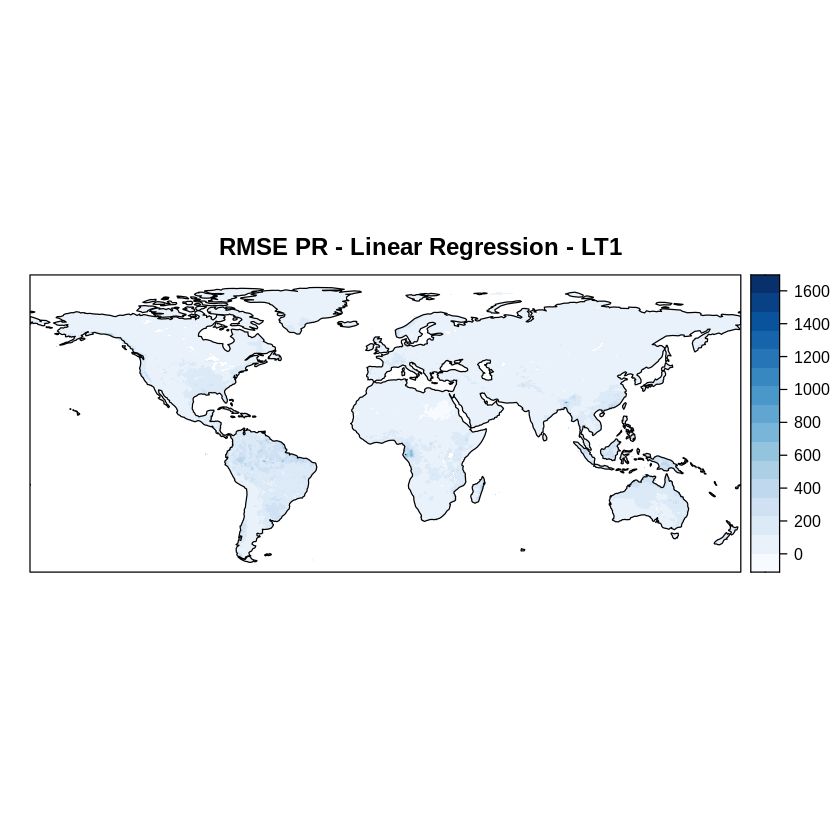

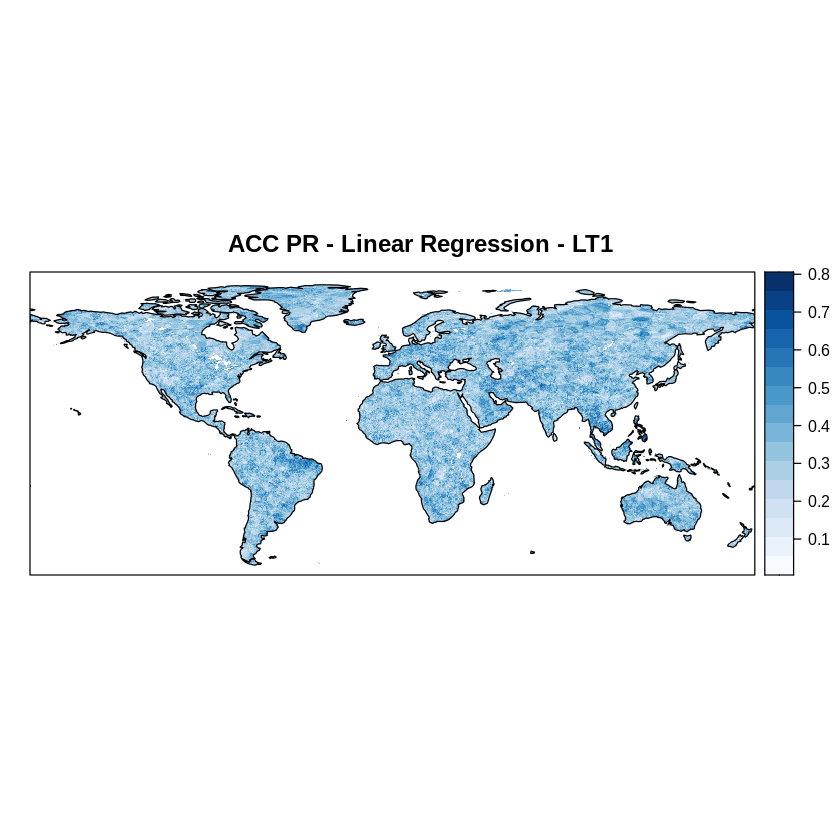

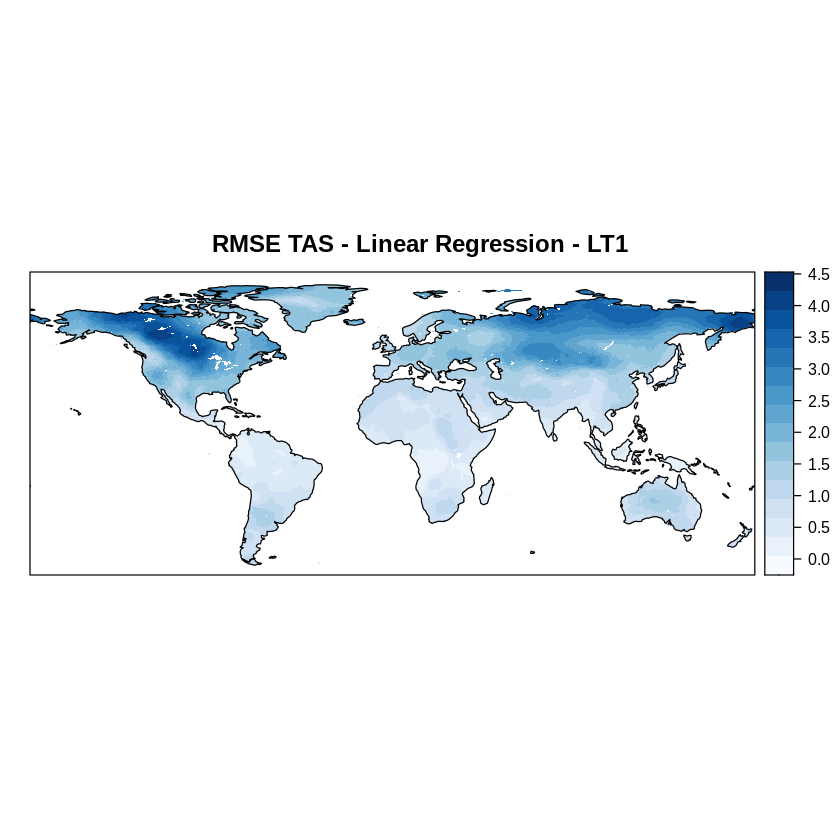

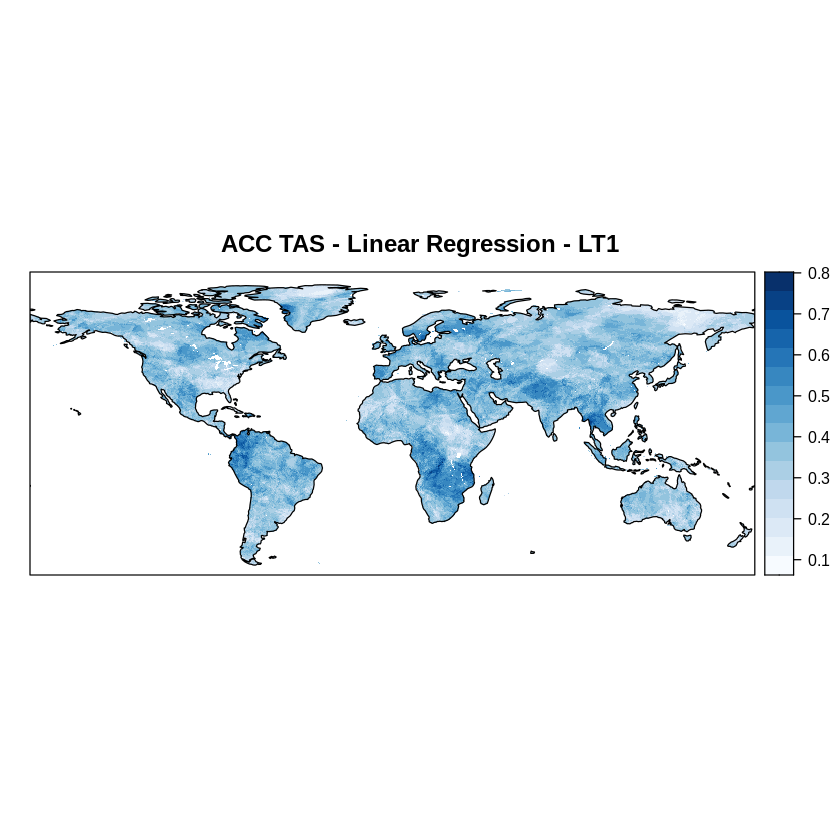

In [15]:
spatialPlot(rmse_pr_regression_LT1, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE PR - Linear Regression - LT1')
spatialPlot(acc_pr_regression_LT1, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC PR - Linear Regression - LT1')
spatialPlot(rmse_tas_regression_LT1, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE TAS - Linear Regression - LT1')
spatialPlot(acc_tas_regression_LT1, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC TAS - Linear Regression - LT1')

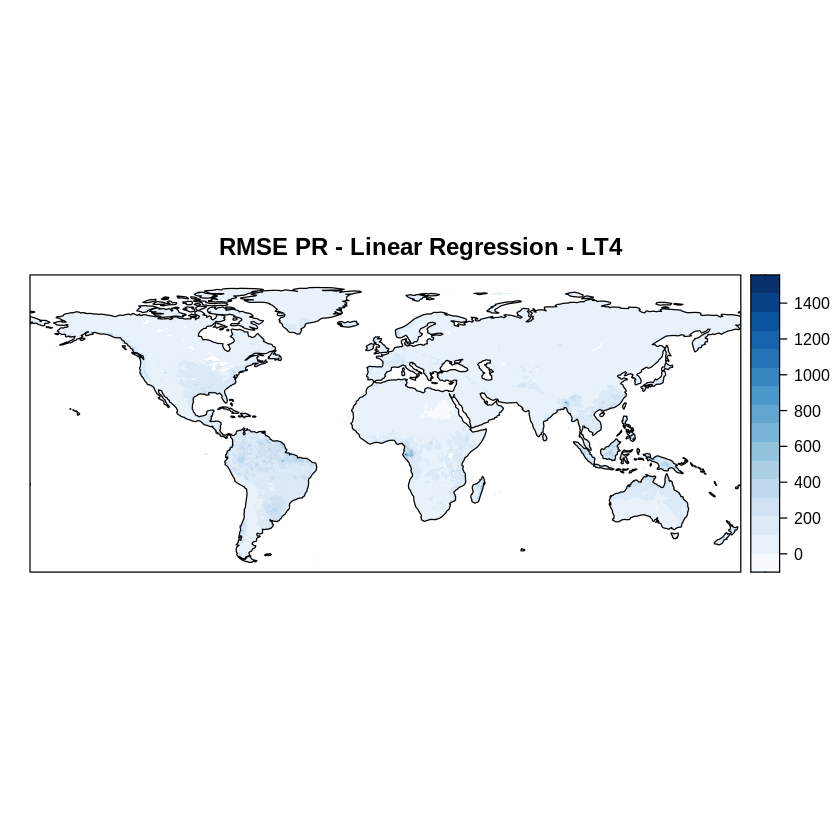

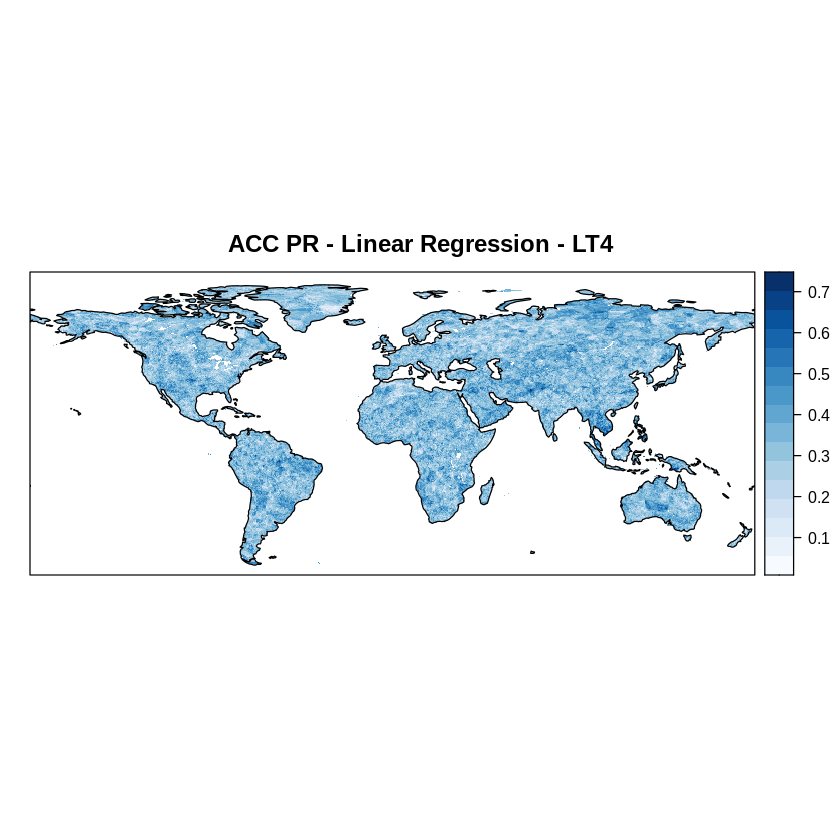

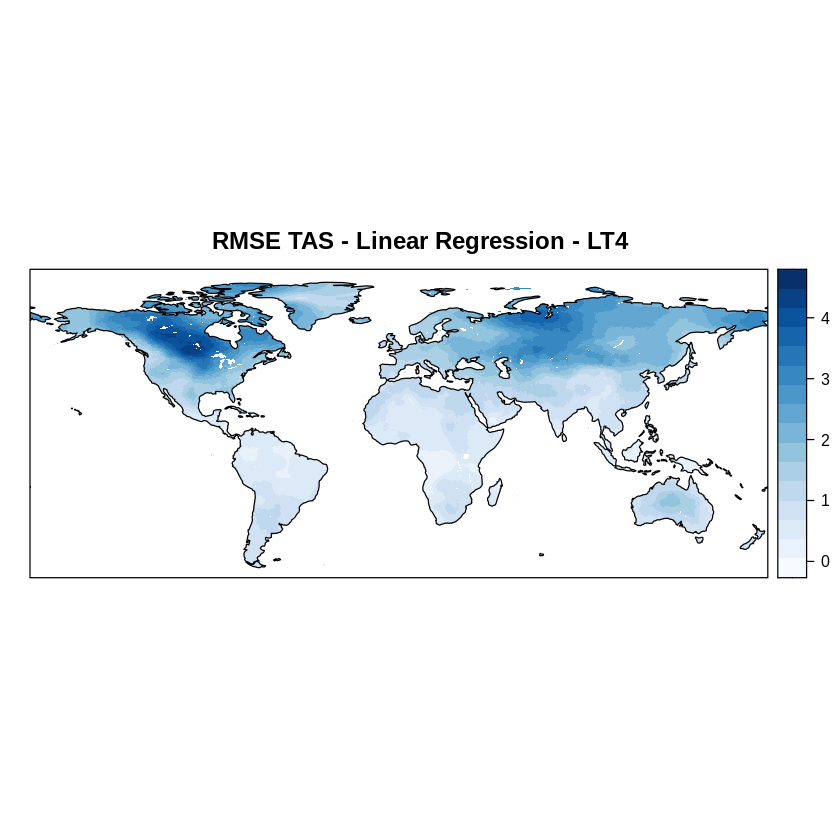

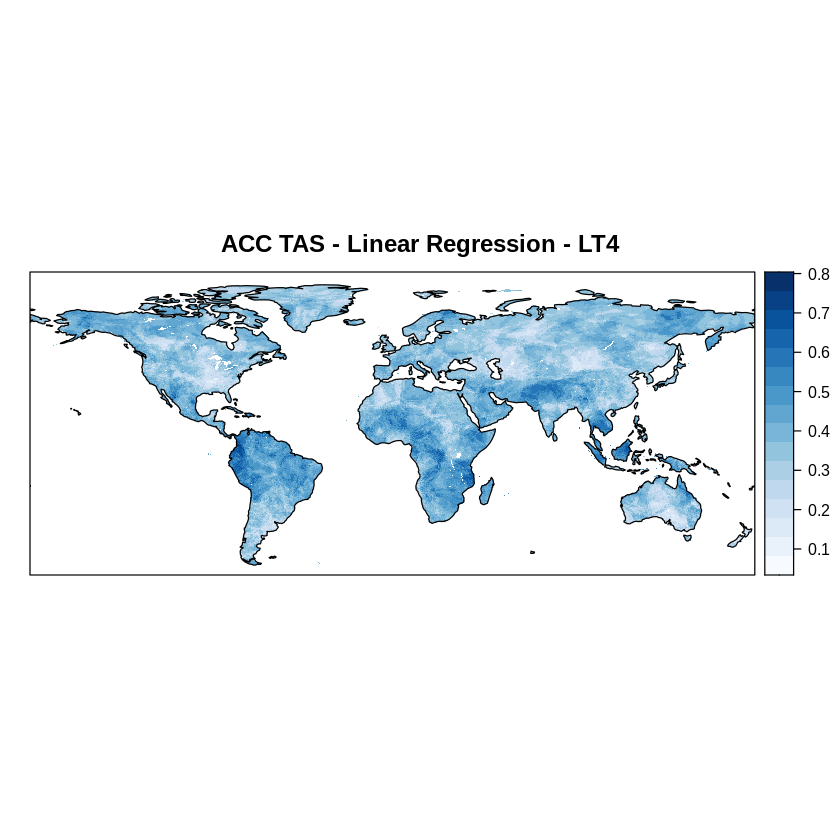

In [16]:
spatialPlot(rmse_pr_regression_LT4, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE PR - Linear Regression - LT4')
spatialPlot(acc_pr_regression_LT4, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC PR - Linear Regression - LT4')
spatialPlot(rmse_tas_regression_LT4, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE TAS - Linear Regression - LT4')
spatialPlot(acc_tas_regression_LT4, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC TAS - Linear Regression - LT4')

## HOLD-OUT

In [17]:
predict_pr_regression_holdout = data_MAM
predict_tas_regression_holdout = data_MAM_temp

In [18]:
start_time = Sys.time()

rmse_pr_regression_holdout = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_pr_regression_holdout = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
for(i in 1:length(data_MAM$xyCoords$x)){
    for(j in 1:length(data_MAM$xyCoords$y)){
        if(length(which(is.na(data_MAM$Data[,j,i])==FALSE))>2){
            indices_MAM$grid = data_MAM$Data[, j,i]
            n = dim(indices_MAM)[1]
            set.seed(2)
            indtrain = sample(1:n, round(0.5*n))
            indtest = setdiff(1:n, indtrain)
            dataset.train = indices_MAM[indtrain, ]
            dataset.test = indices_MAM[indtest, ]
            mod= lm(grid ~nina+oni+nao+poleur+ea+eawr+pna+scand+soi+wp, data = dataset.train,
                       na.action = na.omit)

            pred= predict(mod, dataset.test)
                
            rmse_pr_regression_holdout[j,i] = rmse(dataset.test$grid,pred)
            acc_pr_regression_holdout[j,i] = acc(dataset.test$grid,pred)
        }
    }
}


end_time = Sys.time()
print(end_time - start_time)



Time difference of 1.864636 mins


In [19]:
start_time = Sys.time()

rmse_tas_regression_holdout = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
acc_tas_regression_holdout = matrix(NA, nrow = length(data_MAM$xyCoords$y), ncol = length(data_MAM$xyCoords$x))
for(i in 1:length(data_MAM_temp$xyCoords$x)){
    for(j in 1:length(data_MAM_temp$xyCoords$y)){
        if(length(which(is.na(data_MAM_temp$Data[,j,i])==FALSE))>2){
            indices_MAM$grid = data_MAM_temp$Data[, j,i]
            n = dim(indices_MAM)[1]
            set.seed(2)
            indtrain = sample(1:n, round(0.5*n))
            indtest = setdiff(1:n, indtrain)
            dataset.train = indices_MAM[indtrain, ]
            dataset.test = indices_MAM[indtest, ]
            mod= lm(grid ~nina+oni+nao+poleur+ea+eawr+pna+scand+soi+wp, data = dataset.train,
                       na.action = na.omit)

            pred= predict(mod, dataset.test)
                
            rmse_tas_regression_holdout[j,i] = rmse(dataset.test$grid,pred)
            acc_tas_regression_holdout[j,i] = acc(dataset.test$grid,pred)
        }
    }
}


end_time = Sys.time()
print(end_time - start_time)

Time difference of 1.870219 mins


In [20]:
makeC4R = function(data, template) {  # creates a C4R object from the "data" matrix
  C4R = template; C4R$Data = data; attributes(C4R$Data) = attributes(template$Data)
  return(C4R)
}
template = subsetDimension(data_MAM, dimension = "time", indices = 1)
rmse_pr_regression_holdout= makeC4R(rmse_pr_regression_holdout,template)
acc_pr_regression_holdout= makeC4R(acc_pr_regression_holdout,template)

rmse_tas_regression_holdout= makeC4R(rmse_tas_regression_holdout,template)
acc_tas_regression_holdout= makeC4R(acc_tas_regression_holdout,template)

In [21]:
library(RColorBrewer)
colstx <- rev(brewer.pal(n = 9, "Spectral"))
colsindex <- rev(brewer.pal(n = 9, "RdYlBu"))
colsdelta <- brewer.pal(n = 9, "Reds")
colsbias <- brewer.pal(n = 9, "PiYG")
colssd <- brewer.pal(n = 9, "Blues")

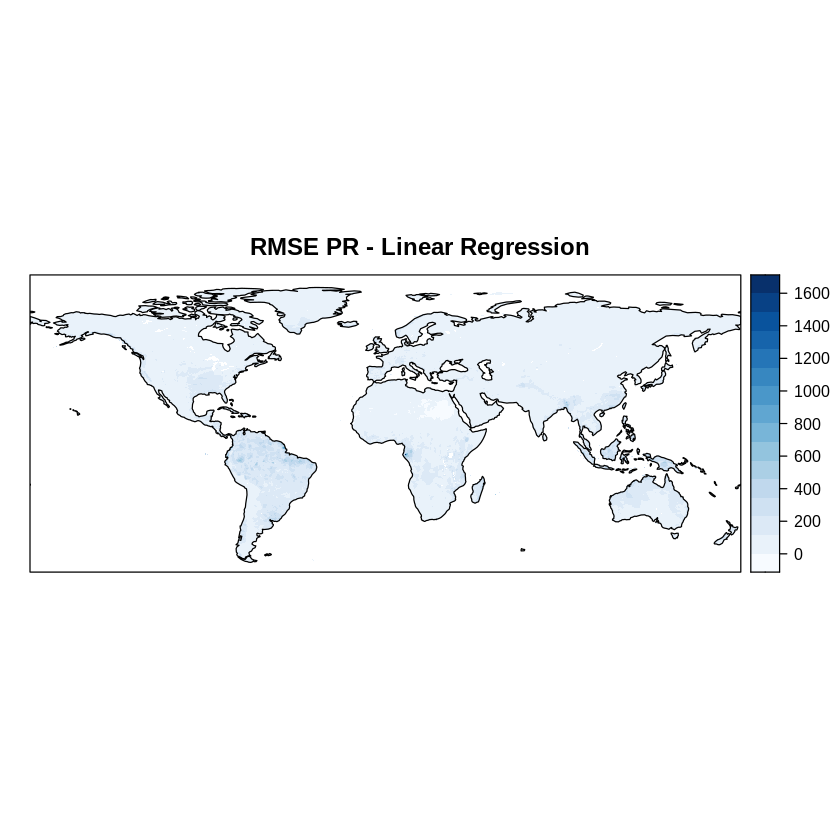

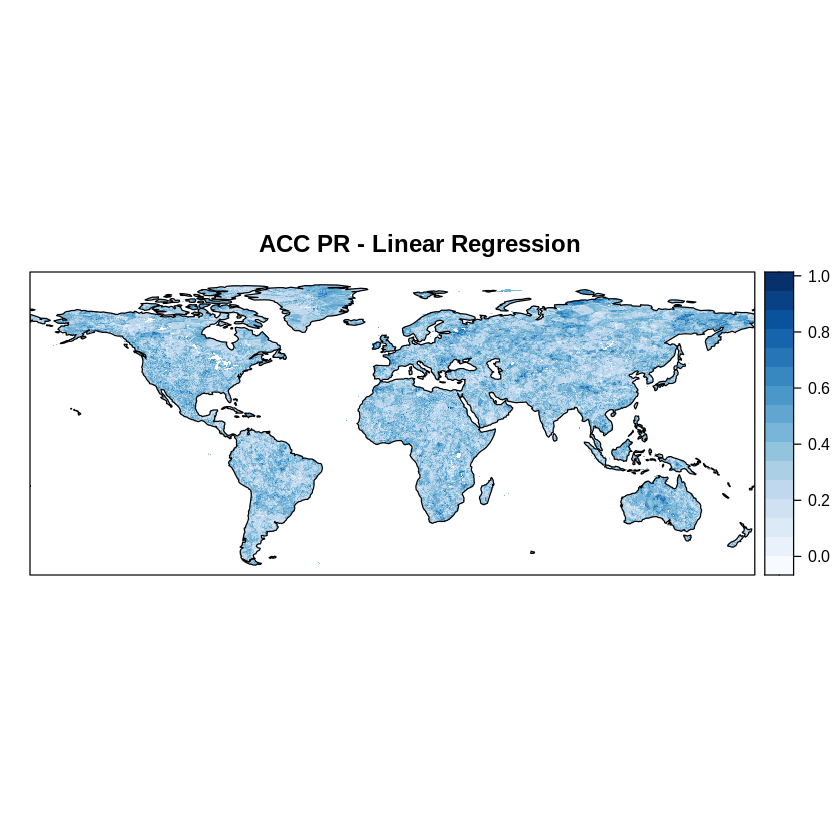

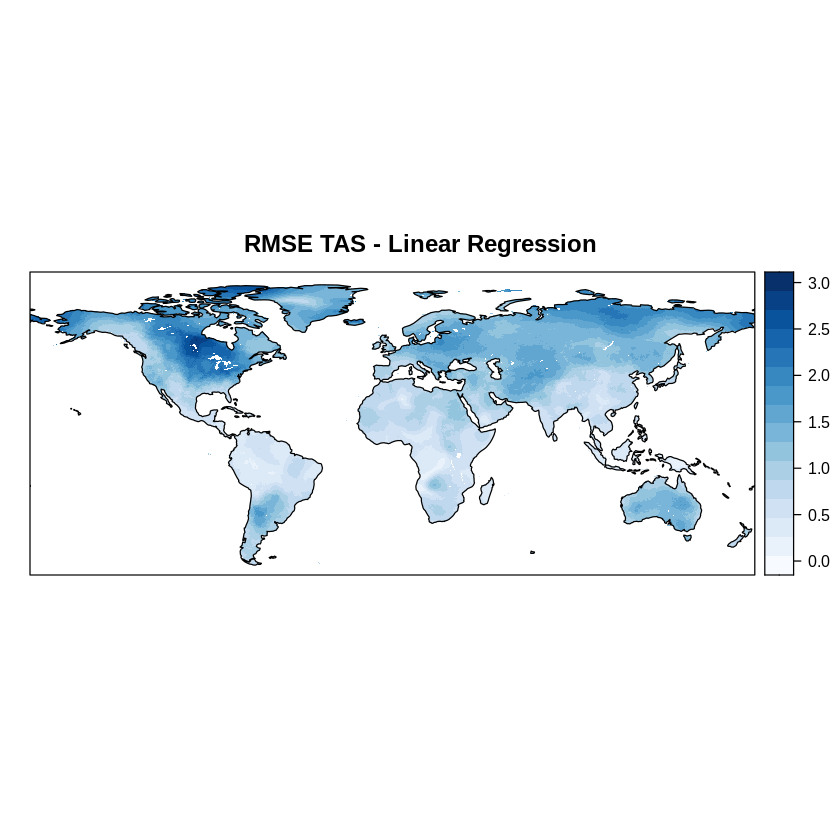

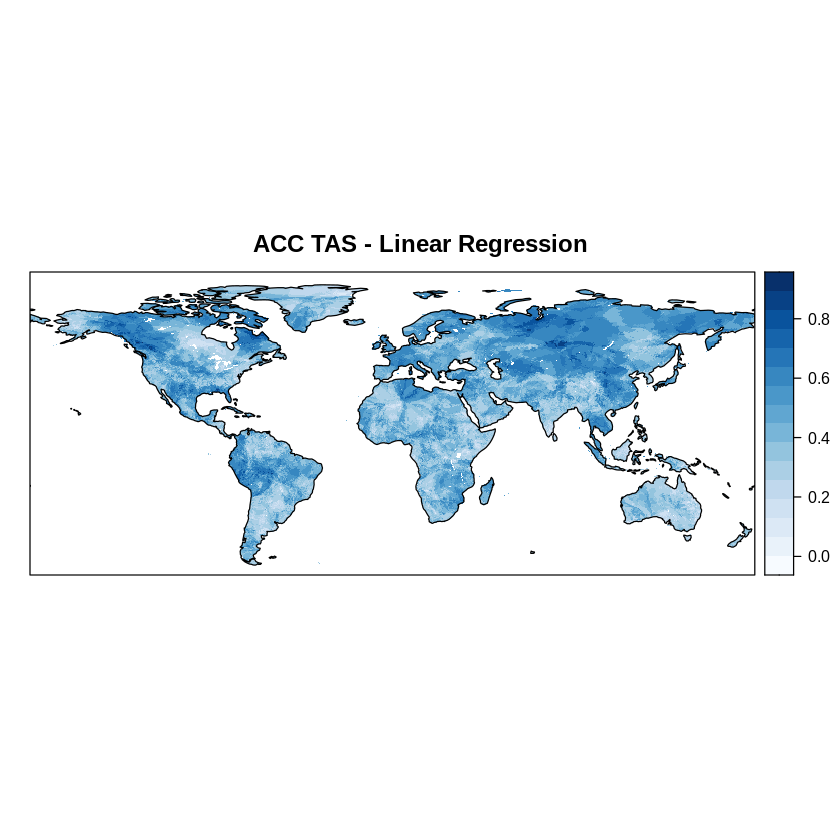

In [22]:
spatialPlot(rmse_pr_regression_holdout, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE PR - Linear Regression')
spatialPlot(acc_pr_regression_holdout, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC PR - Linear Regression')
spatialPlot(rmse_tas_regression_holdout, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'RMSE TAS - Linear Regression')
spatialPlot(acc_tas_regression_holdout, backdrop.theme = "coastline", col.regions = colorRampPalette(colssd),
            main = 'ACC TAS - Linear Regression')